In [1]:
import os
import rpy2
import logging
import warnings
import anndata2ri
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
from tabnanny import verbose
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from functions import pathway_analyses

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.5.0
anndata2ri                  1.1
appnope                     0.1.3
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
comm                        0.1.3
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
decoupler                   1.4.0
executing                   1.2.0
functions                   NA
google                      NA
gsva_prep                   NA
h5py                        3.9.0
igraph                      0.10.4
ipykernel                   6.23.2
ipywidgets                  8.0.6
jedi                        0.18.2
jinja2                      3.1.2
joblib                      1.2.0
kiwisolver                  1.4.4
leidenalg                   0.9.1
llvmlite                    0.39.1
louvain                     0.8.0
markupsafe 

In [4]:
%%R

suppressPackageStartupMessages({
  
library(EnhancedVolcano)
library(circlize)
library(GSEABase)
library(GSVA) 
library(ComplexHeatmap)
library(UpSetR)

library(VennDiagram)
library(gridExtra)
library(Seurat)
library(Signac)
library(tidyverse)
library(future.apply)
library(ggpubr)
library(reshape2)
library(tictoc)

library(patchwork)
library(ggridges)
library(RColorBrewer)
library(eulerr)
library(GeneOverlap)
library(readxl)
library(ComplexHeatmap)
library(circlize)
library(tidyr)

library(readxl)
library(ComplexHeatmap)
library(circlize)
library(tidyr)

})

# # using the cowplot theme for ggplot
# theme_set(theme_cowplot())

# # set random seed for reproducibility
# set.seed(12345)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In addition: Warning messages:
1: package ‘AnnotationDbi’ was built under R version 4.3.1 
2: package ‘IRanges’ was built under R version 4.3.1 
3: package ‘S4Vectors’ was built under R version 4.3.1 
4: package ‘GSVA’ was built under R version 4.3.1 


In [5]:
cell_types = ["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC",] # cell types on which meta analysis will be computed

studies = ['seaad_mtg', 'leng_etc', 'leng_sfg'] # list of studies in the meta-analysis

tests = ['early_vs_no', 'late_vs_early', 'ad_vs_no', 'late_vs_no'] # list of test names to consider

go_node_depths = [1, 2, 3, 4, 5, 6, 7, 8] # list of depths to obtain gene ontology biological process parents

deg_methods =  ['DESeq2-Wald']

color_scheme_celltype = {}

color_scheme_celltype['Excitatory'] = 'aquamarine3'
color_scheme_celltype['Inhibitory'] = 'darkolivegreen3'
color_scheme_celltype['Astrocyte'] = 'brown3'
color_scheme_celltype['Oligodendrocyte'] = 'darkorchid3'
color_scheme_celltype['Microglia'] = 'deepskyblue3'
color_scheme_celltype['OPC'] = 'deeppink3'


color_scheme_celltype =  robjects.ListVector(
                        {
                            cell_type: color_scheme_celltype[cell_type]
                     
                            for cell_type in cell_types
                        }
                    )



## **Parse Gene Core ontology (OBO Format)**

This is the basic version of the GO, filtered such that the graph is guaranteed to be acyclic and annotations can be propagated up the graph. The relations included are is a, part of, regulates, negatively regulates and positively regulates. This version excludes relationships that cross the 3 GO hierarchies.

The parsing is done with [**goscripts**](https://pmoris.github.io/goscripts/_build/html/source/README.html), a python script and package for Gene Ontology enrichment analysis.

In [6]:
from goscripts.goscripts.obo_tools import importOBO, completeChildHierarchy, buildGOtree

GOdict = importOBO('../data/pathway_databases/go_terms.obo', ignore_part_of=True)
# Generate the entire GO tree’s parent structure by walking through the hierarchy of each GO entry

Retrieved 47497 GO terms from /Users/tadeoye/Documents/Research codes/systematic_ad_analysis/data/pathway_databases/go_terms.obo 

Adding secondary GO identifiers...



Next we build the entire GO tree parent and child structure for only `Biological Processes with GO ID GO:0008150` by walking through the hierarchy of each GO entry using `buildGOtree` and setting the `root_node = ['GO:0008150']`.

This function assigns all higher order ancestors (recursive parents) for each GO object, assigns immediate children, assigns all recursively found children, assign depth to each node.

In [7]:
# here we set the root node as "Biological Processes with GO ID GO:0008150"
buildGOtree(GOdict, root_nodes=['GO:0008150']) 
#completeChildHierarchy(GOdict) # Generates the entire GO tree’s child structure.

## **Reading in the data**

We load the preprocessed and annotated pathway differential scores for each study across tests specifies in the previosu cells:

In [8]:
# load all pathways
pathway_scores = {}

for study in studies:
    pathway_scores[study] = {}
    for test in tests:
        pathway_scores[study][test] = pd.read_csv(f'../results/{test}/{study}/Data/differentially_expressed_pathways.csv')
        pathway_scores[study][test]['shortened'] = pathway_scores[study][test]['pathway']

In [9]:
for study in studies:

    filtered = pathway_scores[study]['ad_vs_no'][pathway_scores[study]['ad_vs_no']['P.Value']<0.05]
    collated_df = pd.DataFrame(filtered.groupby(filtered.pathway).agg({'score_adj': list, 'celltype': list, 
                        'logFC': list, 'P.Value': list, 'shortened': list, 'highlight': list}))
    # filter pathways only expressed in one cell type
    unique = collated_df["celltype"].apply(len) == 1
    shared = collated_df["celltype"].apply(len) > 1

    print(f'{study.upper()} has {sum(unique)/len(unique)*100}% UNIQUE PATHWAYS and {sum(shared)/len(unique)*100} SHARED PATHWAYS')


    for cell_type in cell_types:
        total_paths = len(pathway_scores[study]['ad_vs_no'][(pathway_scores[study]['ad_vs_no']['P.Value']<0.05)&
                                                        (pathway_scores[study]['ad_vs_no']['celltype']==cell_type)])
        
        up_paths = len(pathway_scores[study]['ad_vs_no'][(pathway_scores[study]['ad_vs_no']['P.Value']<0.05)&
                                                        (pathway_scores[study]['ad_vs_no']['celltype']==cell_type)&
                                                        (pathway_scores[study]['ad_vs_no']['logFC']>0)])

        down_paths = len(pathway_scores[study]['ad_vs_no'][(pathway_scores[study]['ad_vs_no']['P.Value']<0.05)&
                                                        (pathway_scores[study]['ad_vs_no']['celltype']==cell_type)&
                                                        (pathway_scores[study]['ad_vs_no']['logFC']<0)])

        

        print(f'in {study.upper()} there are a total of {total_paths} dysregulated pathways in {cell_type}')
        print(f'in {study.upper()} {down_paths/total_paths*100}% pathways in {cell_type} are DOWNreguled')
        print(f'in {study.upper()} {up_paths/total_paths*100}% pathways in {cell_type} are UPreguled')
        print("***********")    
    print('================================================')

SEAAD_MTG has 73.12680115273776% UNIQUE PATHWAYS and 26.87319884726225 SHARED PATHWAYS
in SEAAD_MTG there are a total of 333 dysregulated pathways in Excitatory
in SEAAD_MTG 60.66066066066066% pathways in Excitatory are DOWNreguled
in SEAAD_MTG 39.33933933933934% pathways in Excitatory are UPreguled
***********
in SEAAD_MTG there are a total of 355 dysregulated pathways in Inhibitory
in SEAAD_MTG 56.61971830985916% pathways in Inhibitory are DOWNreguled
in SEAAD_MTG 43.38028169014084% pathways in Inhibitory are UPreguled
***********
in SEAAD_MTG there are a total of 195 dysregulated pathways in Astrocyte
in SEAAD_MTG 40.0% pathways in Astrocyte are DOWNreguled
in SEAAD_MTG 60.0% pathways in Astrocyte are UPreguled
***********
in SEAAD_MTG there are a total of 340 dysregulated pathways in Microglia
in SEAAD_MTG 41.17647058823529% pathways in Microglia are DOWNreguled
in SEAAD_MTG 58.82352941176471% pathways in Microglia are UPreguled
***********
in SEAAD_MTG there are a total of 287 dys

### **Get parent GO name at a certain node**

In [10]:
def get_parent_at_depth(goid, depth, GOdict):
    
    """
    Given a Gene Ontology (GO) term ID and a desired depth in the GO hierarchy, this function returns the name of the
    first parent GO term at that depth.

    Parameters:
    -----------
    - goid (str): A string representing the GO term ID.
    - depth (int): An integer representing the desired depth in the GO hierarchy.

    Returns:
    --------
    - str: The name of the parent GO term at the desired depth in the GO hierarchy.

    """
        
    for parent in GOdict.get(goid).recursive_parents:
        if GOdict.get(parent).depth == depth:
            return GOdict.get(parent).name
        else:
            continue

### **Obtain And Save Overall Overlap**

This section computes the overall overlap of pathways across all studies and generates a complete hierarchy of pathway nodes, including the parent name at each node.

In [11]:

for test_name in tests:
    eval_string = []
    for i, study in enumerate(pathway_scores.keys()):
        eval_string.append(f'set(pathway_scores["{study}"]["{test_name}"][pathway_scores["{study}"]["{test_name}"]["P.Value"]<0.05].pathway)')

    eval_string = '&'.join(eval_string)
    eval_list = list(eval(eval_string))
    df = pd.DataFrame()
    df['pathway'] = eval_list
    df['GO'] = [pathway.split(' ')[-1].strip('(').strip(')') for pathway in eval_list]
    
    for depth in go_node_depths:
        df[f'parent_at_node_{depth}'] = df['GO'].apply(lambda x: get_parent_at_depth(x, depth, GOdict))

    dat_dir = f'../results/{test_name}/Consensus/'

    if not os.path.exists(dat_dir):
        os.makedirs(dat_dir)
    
    df.to_csv(dat_dir+'pathway_overlap.csv')

Next, we load a list of manually curated annotated pathways that we are interested in plotting. We then assign the parent at each node using the function `get_parent_at_depth()`.

In [12]:
pathways_to_annotate = pd.read_excel('../data/pathway_databases/pathways_to_annotate.xlsx')
pathways_to_annotate['GO'] = pathways_to_annotate['pathway'].apply(lambda x: x.split(' ')[-1].strip('(').strip(')'))

for depth in go_node_depths:
        pathways_to_annotate[f'parent_at_node_{depth}'] = pathways_to_annotate['GO'].apply(lambda x: get_parent_at_depth(x, depth, GOdict))

View list of unique parents at a certain node

In [13]:
pathways_to_annotate['parent_at_node_3'].unique()

array(['regulation of catalytic activity', None,
       'positive regulation of molecular function', 'defense response',
       'lipid homeostasis', 'cell surface receptor signaling pathway',
       'G protein-coupled receptor signaling pathway',
       'macromolecule metabolic process', 'amide metabolic process',
       'monoatomic ion transmembrane transport',
       'establishment of organelle localization', 'cell differentiation',
       'cellular aromatic compound metabolic process', 'autophagy',
       'cellular component organization', 'developmental cell growth',
       'cellular response to stress', 'cellular component morphogenesis',
       'transport', 'secretion by cell',
       'inorganic ion transmembrane transport', 'cell-cell adhesion',
       'intracellular signal transduction', 'monoatomic ion homeostasis',
       'response to oxygen-containing compound', 'axon ensheathment',
       'cell migration', 'signaling',
       'regulation of DNA-binding transcription factor 

Based on the pathways of interest, we can curate a list of parent nodes for each level. Only pathways that belong to those parents at each level will be selected for visualization.

In [14]:
parents_to_annotate = {
                        'node_1': [None,
                                   'immune system process',
                                   'cellular process',
                                   'metabolic process',
                                   'biological regulation',
                                   'response to stimulus',
                                   'homeostatic process',
                                   'localization',
                                  ],

############### PATHWAYS AT NODE 2 #############################################                                    

                        'node_2': [None,
                                   'regulation of molecular function',
                                   'response to stress',
                                   'chemical homeostasis',
                                   'regulation of biological process',
                                   'organic substance metabolic process',
                                   'establishment of localization',
                                   'cellular developmental process',
                                   'small molecule metabolic process',
                                   'cellular metabolic process',
                                   'cellular component organization or biogenesis',
                                   'developmental growth',
                                   'cellular response to stimulus',
                                   'cell recognition',
                                   'transmembrane transport',
                                   'cell adhesion',
                                   'catabolic process',
                                   'cellular homeostasis',
                                   'ensheathment of neurons',
                                   'cell motility',
                                   'signal transduction',
                                   'response to chemical',
                                   'regulation of biological quality',
                                   'activation of immune response',
                                   'regulation of pH',
                                   'maintenance of location',
                                   'leukocyte activation',
                                   'anatomical structure formation involved in morphogenesis',
                                   'cell death',
                                   'cellular localization',
                                   'protein-containing complex localization',
                                   'meiotic cell cycle process',
                                   'membrane docking',
                                   'actin filament-based process'
                                   ],

############### PATHWAYS AT NODE3  #############################################      
#                               
                        "node_3": [None,
                                   'regulation of catalytic activity',
                                    'positive regulation of molecular function', 
                                    'defense response', 
                                    'lipid homeostasis',
                                    'G protein-coupled receptor signaling pathway',
                                    'macromolecule metabolic process', 
                                    'amide metabolic process',
                                    'establishment of localization in cell', 
                                    'cell differentiation',
                                    'nucleobase-containing small molecule metabolic process',
                                    'cellular component organization', 
                                    'developmental cell growth',
                                    'cellular response to stress', 
                                    'import across plasma membrane',
                                    'transport', 'cell-cell adhesion',
                                    'regulation of cellular process', 
                                    'monoatomic ion homeostasis',
                                    'cellular response to chemical stimulus', 
                                    'axon ensheathment',
                                    'cell migration', 
                                    'cell-cell signaling', 
                                    'nervous system process',
                                    'intracellular transport', 
                                    'response to salt',
                                    'vesicle localization', 
                                    'regulation of membrane potential',
                                    'cell development', 
                                    'amino acid metabolic process',
                                    'organic acid metabolic process',
                                    'cell surface receptor signaling pathway',
                                    'regulation of immune system process', 
                                    'cell-cell recognition',
                                    'organic hydroxy compound metabolic process',
                                    'regulation of cellular pH', 
                                    'maintenance of protein location',
                                    'glial cell activation',
                                    'regulation of multicellular organismal process',
                                    'cellular component assembly involved in morphogenesis',
                                    'regulation of metabolic process', 
                                    'regulation of localization',
                                    'cellular macromolecule localization',
                                    'positive regulation of biological process',
                                    'negative regulation of molecular function',
                                    'regulation of DNA-binding transcription factor activity',
                                    'neuron death', 
                                    'carbohydrate derivative metabolic process',
                                    'localization within membrane',
                                    'positive regulation of cytosolic calcium ion concentration',
                                    'regulation of growth', 
                                    'regulation of developmental process',
                                    'regulation of locomotion', 
                                    'regulation of response to stimulus',
                                    'response to nitrogen compound', 
                                    'response to wounding',
                                    'organelle localization by membrane tethering',
                                    ],

############### PATHWAYS AT NODE 5 ############################################# 
#                                    
                        "node_5": [None,
                                   'positive regulation of cyclase activity',
                                   'positive regulation of hydrolase activity', 
                                   'adenylate cyclase-activating G protein-coupled receptor signaling pathway',
                                   'adenylate cyclase-inhibiting G protein-coupled receptor signaling pathway',
                                   'synaptic vesicle cytoskeletal transport',
                                   'nucleoside triphosphate metabolic process',
                                   'organelle disassembly',
                                   'plasma membrane bounded cell projection organization',
                                   'neuron projection extension involved in neuron projection guidance',
                                   'mitochondrion transport along microtubule',
                                   'cell projection morphogenesis',
                                   'calcium ion transmembrane transport',
                                   'monoatomic cation transport', 
                                   'regulated exocytosis',
                                   'calcium-mediated signaling', 
                                   'ribonucleotide metabolic process',
                                   'cell-cell junction organization',
                                   'intracellular monoatomic cation homeostasis',
                                   'response to amyloid-beta', 
                                   'telencephalon cell migration',
                                   'cyclic-nucleotide-mediated signaling', 
                                   'trans-synaptic signaling',
                                   'endocytosis',
                                   'regulation of G protein-coupled receptor signaling pathway',
                                   'endoplasmic reticulum organization',
                                   'proteasomal protein catabolic process', 
                                   'synapse organization',
                                   'glutamine family amino acid metabolic process',
                                   'positive regulation of immune response',
                                   'mitochondrion organization', 
                                   'protein processing',
                                   'modulation of chemical synaptic transmission',
                                   'plasma membrane organization',
                                   'negative regulation of cyclase activity',
                                   'regulation of protein metabolic process',
                                   'negative regulation of cellular component organization',
                                   'regulation of monoatomic ion transport',
                                   'regulation of exocytosis',
                                   'regulation of intracellular signal transduction',
                                   'negative regulation of nitrogen compound metabolic process',
                                   'regulation of cell projection organization',
                                   'negative regulation of signal transduction',
                                   'regulation of programmed cell death',
                                   'positive regulation of cell communication',
                                   'regulation of defense response',
                                   'regulation of protein transport',
                                   'regulation of intracellular transport',
                                   'regulation of nervous system development',
                                   'regulation of neural precursor cell proliferation',
                                   'negative regulation of cell differentiation',
                                    'regulation of response to endoplasmic reticulum stress',
                                    'regulation of receptor binding',
                                    'positive regulation of macromolecule metabolic process',
                                    'monoatomic anion transport',
                                    'negative regulation of synaptic transmission',
                                    'regulation of transcription regulatory region DNA binding',
                                    'negative regulation of immune response',
                                    'regulation of cellular biosynthetic process',
                                    'protein-containing complex assembly', 
                                    'chromosome organization',
                                    'glycolipid metabolic process', 
                                    'lipoprotein localization',
                                    'negative regulation of catabolic process', 
                                    'lysosomal transport',
                                    'regulation of extracellular matrix organization',
                                    'regulation of apoptotic signaling pathway',
                                    'regulation of macrophage activation',
                                    'postsynaptic specialization organization',
                                    'membrane invagination',
                                    'regulation of axon extension',
                                    'membrane fusion',
                                    'regulation of monoatomic ion transmembrane transport',
                                    'regulation of adaptive immune response',
                                    'regulation of phosphorus metabolic process',
                                    'positive regulation of vasculature development',
                                    'positive regulation of endocytosis',
                                    'positive regulation of biosynthetic process',
                                    'regulation of cellular catabolic process',
                                    'positive regulation of cell growth',
                                    'extracellular matrix organization',
                                    'regulation of cell adhesion mediated by integrin',
                                    'regulation of endocytosis',
                                    'regulation of nervous system process',
                                    'positive regulation of secretion by cell',
                                    'regulation of lipid transport',
                                    'regulation of glutamate receptor signaling pathway',
                                    'regulation of lipid metabolic process',
                                    'regulation of neuron differentiation',
                                    'positive regulation of cell motility', 
                                    'regulation of secretion',
                                    'positive regulation of protein localization',
                                    'positive regulation of cellular component organization',
                                    'membrane assembly', 
                                    'presynaptic membrane organization',
                                    'protein localization to cell junction',
                                    'regulation of monoatomic ion transmembrane transporter activity',
                                    'regulation of vasculature development',
                                    'regulation of extent of cell growth',
                                    'regulation of response to oxidative stress',
                                    'regulation of DNA metabolic process',
                                    'regulation of neuron death', 
                                    'regulation of cell migration',
                                    'regulation of protein localization',
                                    'regulation of protein-containing complex assembly',
                                    'regulation of cell junction assembly',
                                    'regulation of synapse organization', 
                                    'axo-dendritic transport',
                                    'negative regulation of cell cycle',
                                    'DNA damage checkpoint signaling',
                                    'vesicle-mediated transport in synapse',
                                    'actin filament-based transport',
                                    ],

############### PATHWAYS AT NODE 6 #############################################                                    

                        "node_6": [None,
                                   'positive regulation of adenylate cyclase activity',
                                   # 'regulation of endopeptidase activity',  
                                   'axonal transport',
                                   # 'ribonucleoside triphosphate metabolic process',
                                   # 'mitochondrion disassembly', 
                                   'neuron projection development',
                                   # 'plasma membrane bounded cell projection morphogenesis',
                                   'calcium ion transmembrane import into cytosol',
                                   'metal ion transport', 
                                   # 'cyclic nucleotide metabolic process',
                                   # 'nucleotide catabolic process',
                                   'anterograde trans-synaptic signaling',
                                   'receptor-mediated endocytosis',
                                   'negative regulation of G protein-coupled receptor signaling pathway',
                                   'protein quality control for misfolded or incompletely synthesized proteins',
                                   'synapse assembly', 
                                   # 'dicarboxylic acid catabolic process',
                                   # 'dicarboxylic acid metabolic process',
                                   'negative regulation of protein metabolic process',
                                   'regulation of plasma membrane bounded cell projection organization',
                                   'negative regulation of calcium ion transport',
                                   'regulation of metal ion transport',
                                   'regulation of regulated secretory pathway',
                                   'negative regulation of intracellular signal transduction',
                                   'regulation of protein kinase activity',
                                   'regulation of monoatomic cation transmembrane transport',
                                   'negative regulation of cation channel activity',
                                   'endoplasmic reticulum calcium ion homeostasis',
                                   'negative regulation of programmed cell death',
                                   'positive regulation of intracellular signal transduction',
                                   #'regulation of establishment of protein localization',
                                   'regulation of neurogenesis',
                                   'negative regulation of potassium ion transport',
                                   'regulation of apoptotic process',
                                   'regulation of receptor-mediated endocytosis',
                                   'regulation of synaptic transmission, glutamatergic',
                                   # 'regulation of RNA biosynthetic process',
                                   'neuron projection organization',
                                   'regulation of proteasomal protein catabolic process',
                                   'regulation of phagocytosis', 
                                   #'protein localization to vacuole',
                                   'regulation of calcium-mediated signaling',
                                   # 'positive regulation of extracellular matrix organization',
                                   # 'positive regulation of programmed cell death',
                                   'regulation of microglial cell activation',
                                   'mitochondrial calcium ion homeostasis',
                                   'positive regulation of potassium ion transport',
                                   'positive regulation of calcium ion transport',
                                   'postsynaptic density organization',
                                   'plasma membrane invagination',
                                   'regulation of acute inflammatory response',
                                   'regulation of phosphate metabolic process',
                                   'regulation of neuroinflammatory response',
                                   # 'apoptotic mitochondrial changes',
                                   'positive regulation of amide metabolic process',
                                   'positive regulation of phagocytosis',
                                   'regulation of astrocyte differentiation',
                                   'regulation of autophagy',
                                   'positive regulation of gene expression',
                                   'regulation of sterol transport', 
                                   # 'regulation of neuron migration',
                                   'positive regulation of cell projection organization',
                                   'regulation of protein localization to cell surface',
                                   'positive regulation of sodium ion transport',
                                   'regulation of sodium ion transmembrane transporter activity',
                                   'regulation of synapse assembly',
                                   'regulation of glycoprotein metabolic process',
                                   'regulation of amyloid precursor protein catabolic process',
                                   'regulation of programmed necrotic cell death',
                                   'sarcoplasmic reticulum calcium ion transport',
                                   # 'negative regulation of cell cycle process',
                                   # 'organelle membrane fusion',
                                   ]
                       }

Filter the overall list of pathways of interest using the curated list of parents described above.

In [15]:
list_of_paths_to_annotate = pathways_to_annotate[pathways_to_annotate.parent_at_node_6.isin(parents_to_annotate['node_6'])]['pathway'].to_list()
#list_of_paths_to_annotate = pathways_to_annotate['pathway'].to_list()

### **Heatmap showing select diffentially expressed pathways accross all cell_types in each study**

In [16]:
%%R -i list_of_paths_to_annotate -i tests -i studies -o mat -i cell_types -i color_scheme_celltype


source('../scripts/functions/pathway_analyses.R')

# import the renamed-pathway names

print('importing pathway renaming convention')

path_names_go <- as.data.frame(read_excel('../data/pathway_databases/pathways_to_annotate.xlsx'))
# path_names_go <- data.frame(pathway = unique(path_names_go$pathway))
rownames(path_names_go) <- path_names_go$pathway

# names of pathways that will be annotated
names = as.vector(list_of_paths_to_annotate)
names = rownames(path_names_go)

for (study in studies) {

  for (test_name in tests) {
    # Read in pathway data
    pathway_scores <- as.data.frame(read.csv(sprintf('../results/%s/%s/Data/differentially_expressed_pathways.csv', test_name, study), header=TRUE))
    pathway_scores <- pathway_scores[pathway_scores$pathway %in% rownames(path_names_go), ]
    
    # select only significant pathways
    pathway_scores[abs(pathway_scores$score_adj) < 1.3, "score_adj"] <- 0
    pathway_scores_subset <- pathway_scores[, c("pathway", "celltype", "score_adj")]
    pivot_table <- pathway_scores_subset %>% pivot_wider(names_from = "celltype", values_from = "score_adj")

    pivot_table <- as.data.frame(pivot_table)

    # Set the 'pathway' column as the row names (index)
    row.names(pivot_table) <- pivot_table$pathway
    
    pivot_table$pathway <- NULL
    ct_order <- intersect(cell_types, colnames(pivot_table))
    mat <- pivot_table[, ct_order] 
    mat <-  mat %>%
            mutate_all(~coalesce(., 0))
    
    # draw heatmap for all GO pathways
    unique = mat[unname(rowSums(abs(mat)>1.3)==1),] # obtain cell_type_specific pathways.
    shared_2 = mat[unname(rowSums(abs(mat)>1.3)>1),] # obtain shared pathways

    h1 = get_go_hmap(unique, names, path_names_go, 'shortened_name', cell_type_order=ct_order)
    h2 = get_go_hmap(shared_2, names, path_names_go, 'shortened_name', cell_type_order=ct_order)


    fig_dir = paste0('../results/', test_name, '/', study, '/HeatMap/')

    if (!dir.exists(fig_dir)) {
    dir.create(fig_dir, recursive=TRUE)
    }

    pdf(paste0(fig_dir, 'filtered_diff_exp_paths.pdf'), height = 10, width = 8.5)
    print(h1%v%h2)
    dev.off()
  }
}


[1] "importing pathway renaming convention"
New names:
• `` -> `...1`


### **Barcharts showing the distribution of up- and down-regulated pathways in each celltype for each study**

Directionality of pathways in all studies in EARLY_VS_NO


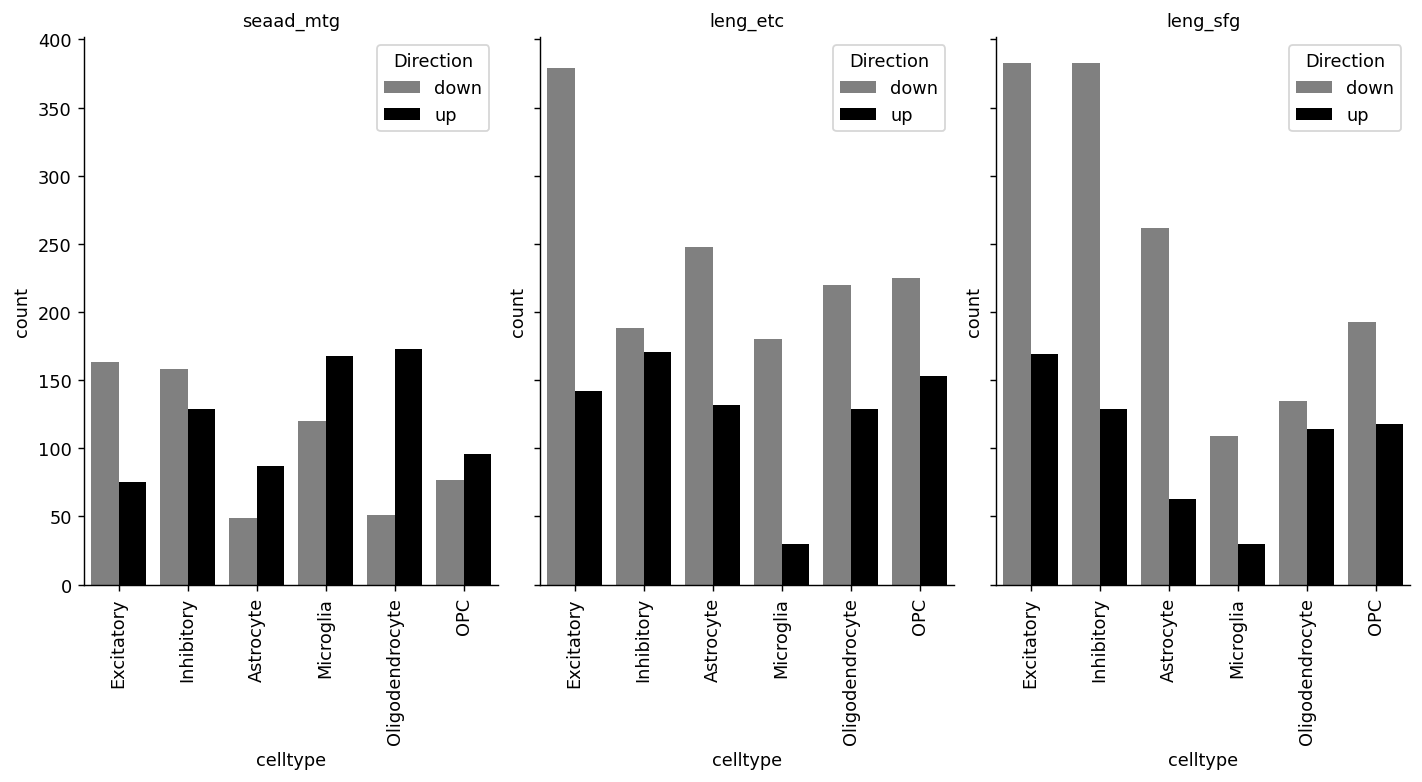

Directionality of pathways in all studies in LATE_VS_EARLY


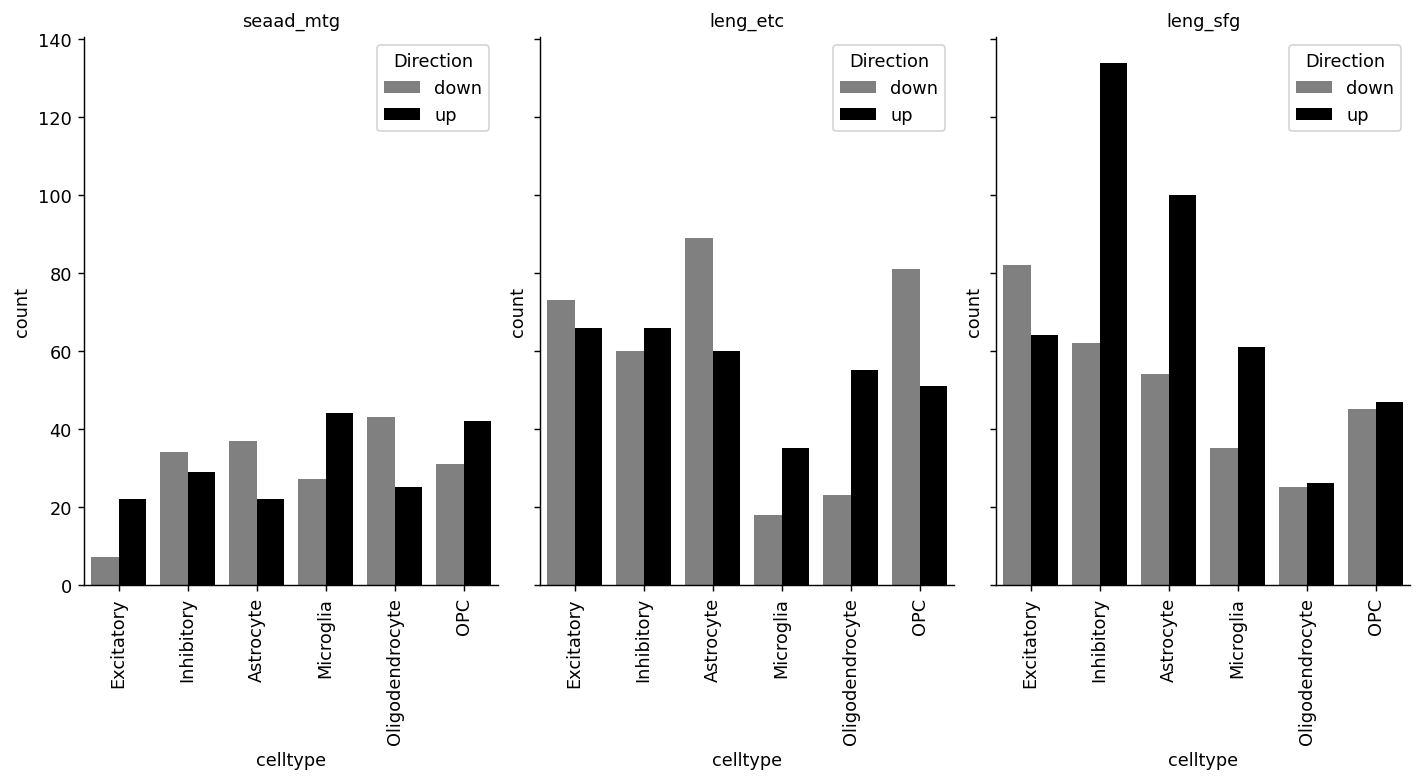

Directionality of pathways in all studies in AD_VS_NO


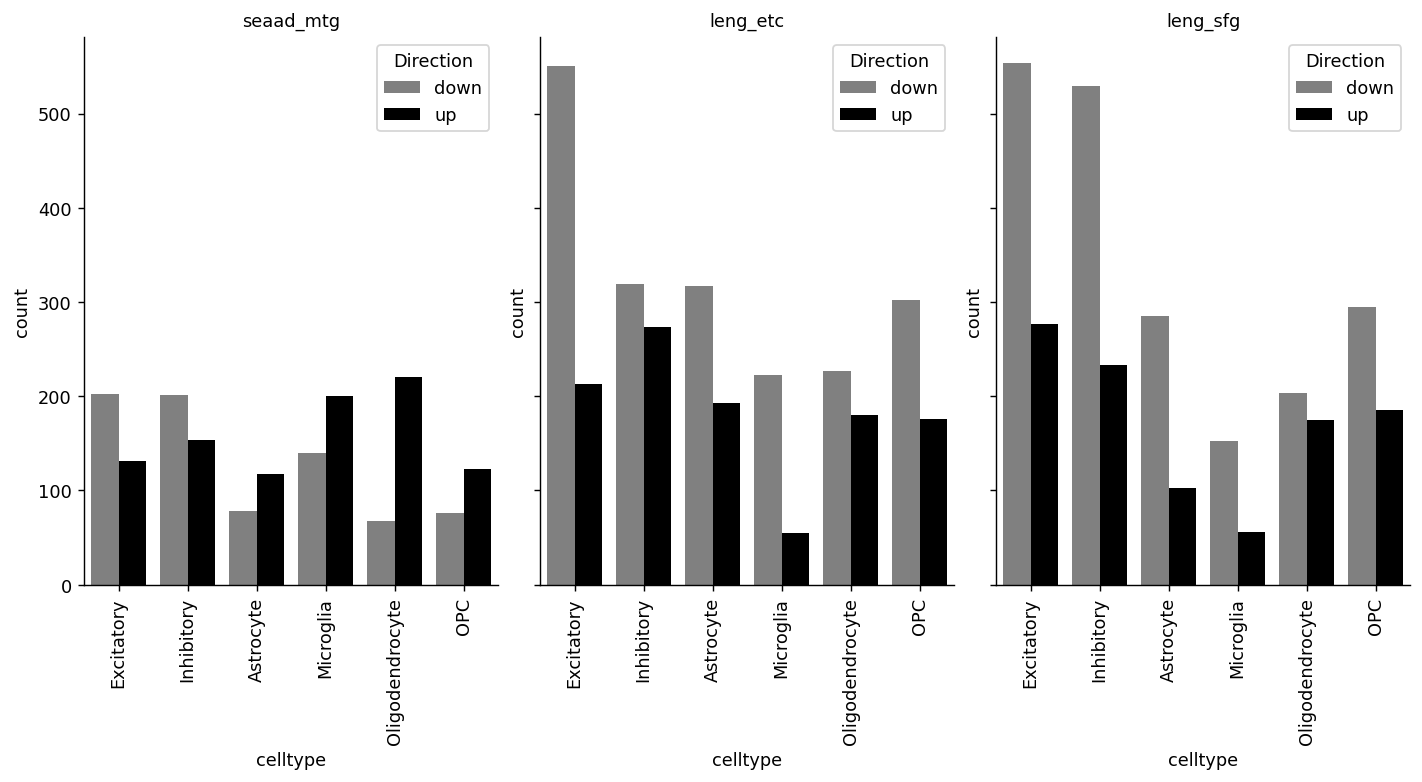

Directionality of pathways in all studies in LATE_VS_NO


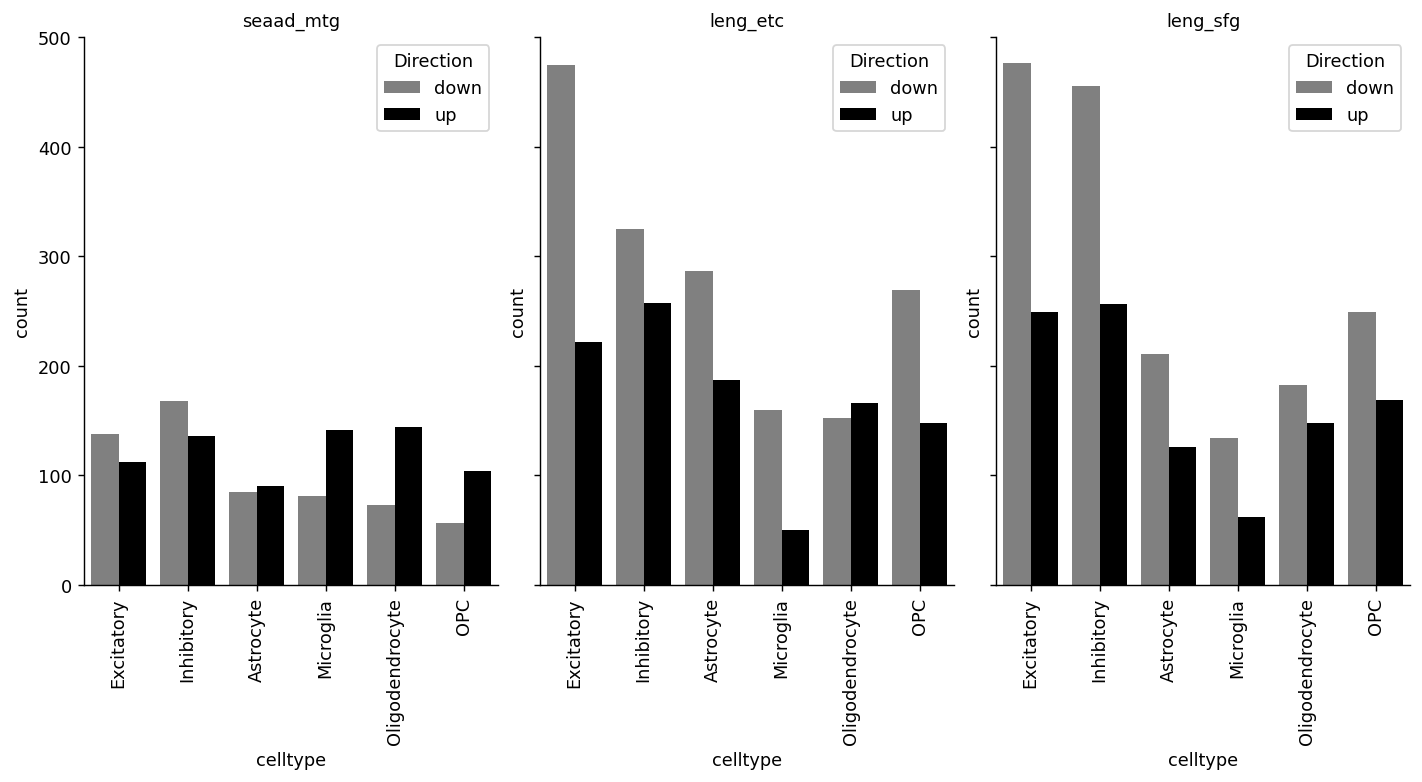

In [17]:
for test_name in tests:
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 6), sharex=False, sharey = True, layout='constrained')
    axs = axs.ravel()

    print(f'Directionality of pathways in all studies in {test_name.upper()}')

    for ind, study in enumerate(studies):
        df = pathway_scores[study][test_name][pathway_scores[study][test_name].celltype.isin(cell_types)]
        df = df[abs(df.score_adj)>1.3]
        df['Direction'] = df.score_adj.apply(lambda x: 'down' if x<0 else "up")

        sb.countplot(data=df, x='celltype', hue='Direction', hue_order=['down', 'up'],
                     ax=axs[ind], linewidth=4, order=cell_types, 
                     palette={'up': 'black', 'down': 'grey'},
                     )

        axs[ind].set_title(study, fontdict={'fontsize': 10})
        axs[ind].yaxis.label.set_fontsize(10)
        axs[ind].set_xticklabels(cell_types, rotation=90,)
        axs[ind].spines[['right', 'top']].set_visible(False)
           

    fig_dir = f'../results/{test_name}/Consensus/Barchat/'

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    plt.savefig(fig_dir+'directionality_distribution_of_pathways.pdf')
    plt.show()
    

### **Barcharts showing the GSVA enrichment score of pathways that are differentially expressed with different directionality across any group of cell_types in each study**

Directionality of pathways in all studies in EARLY_VS_NO
Number of pathways with opposing directionality in SEAAD_MTG: 96
Number of pathways with opposing directionality in LENG_ETC: 64
Number of pathways with opposing directionality in LENG_SFG: 21


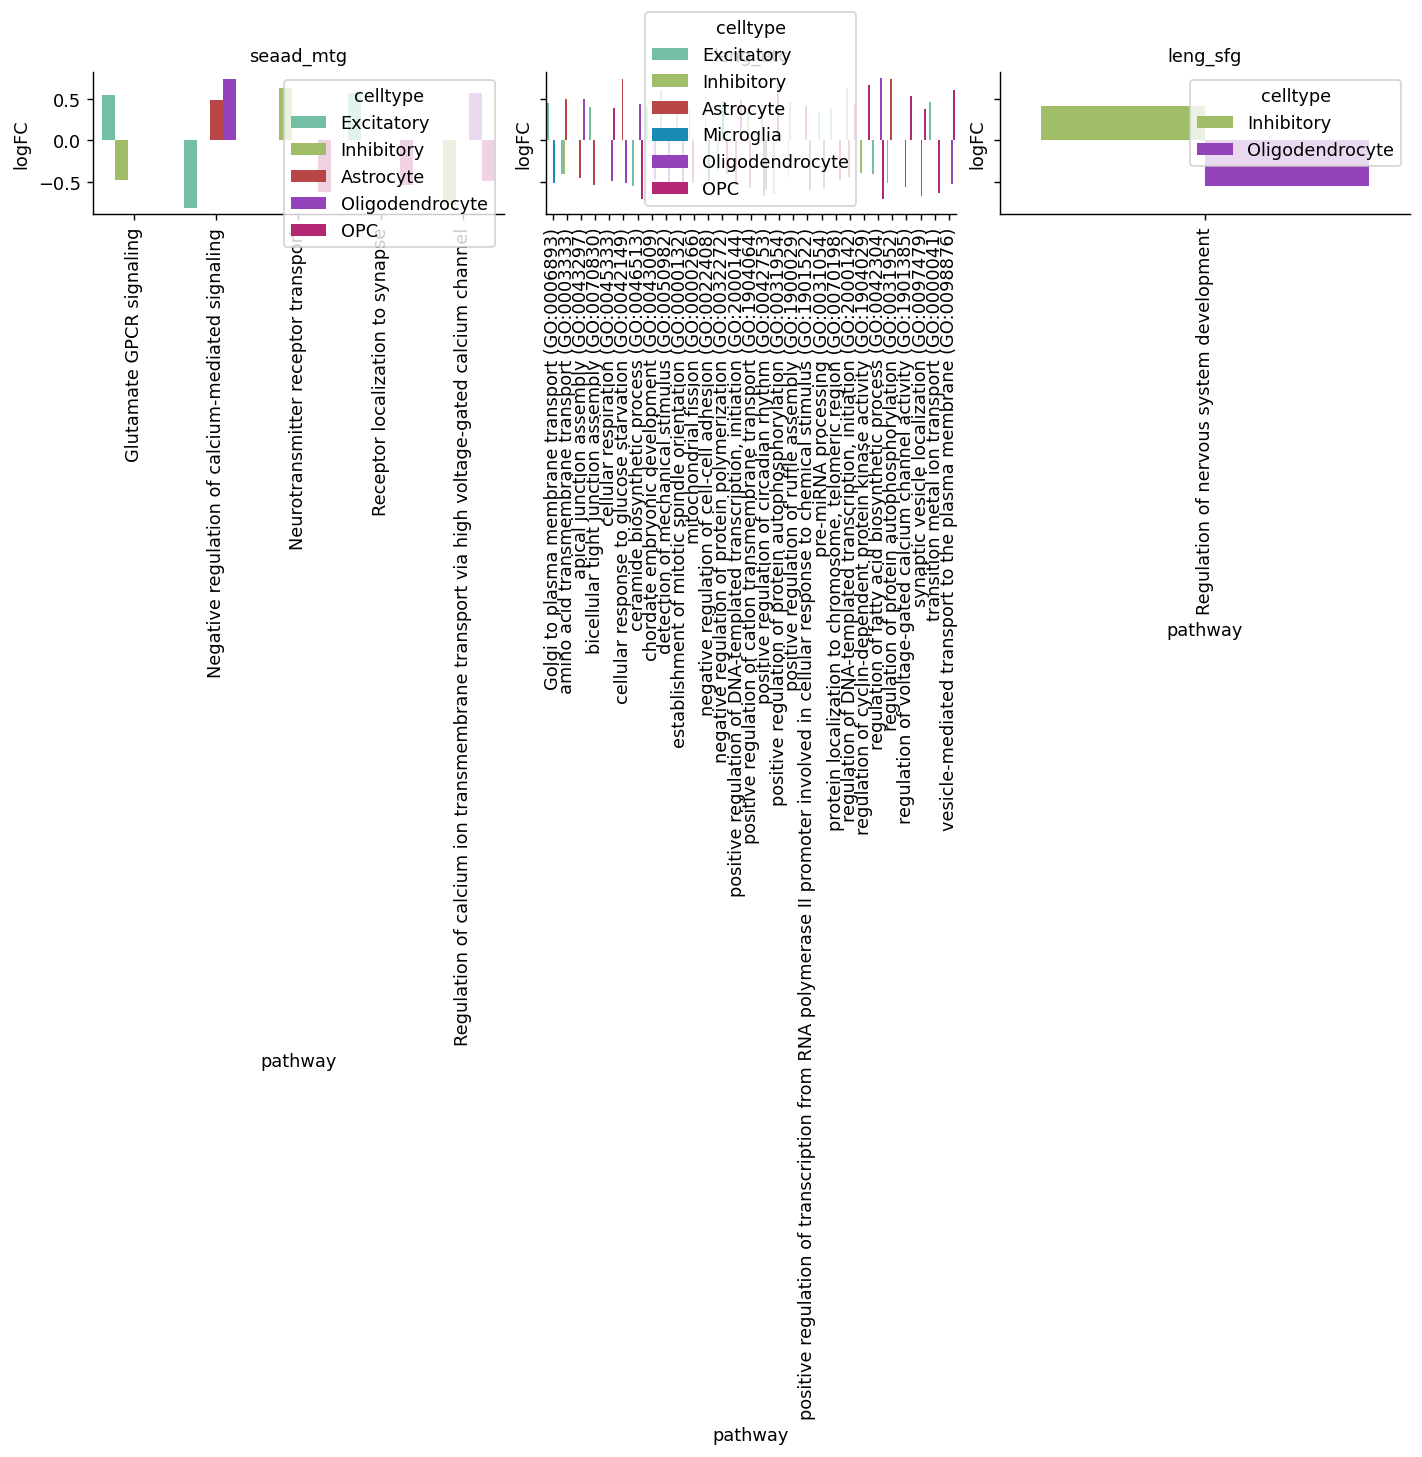

Directionality of pathways in all studies in LATE_VS_EARLY
Number of pathways with opposing directionality in SEAAD_MTG: 11
Number of pathways with opposing directionality in LENG_ETC: 22
Number of pathways with opposing directionality in LENG_SFG: 35


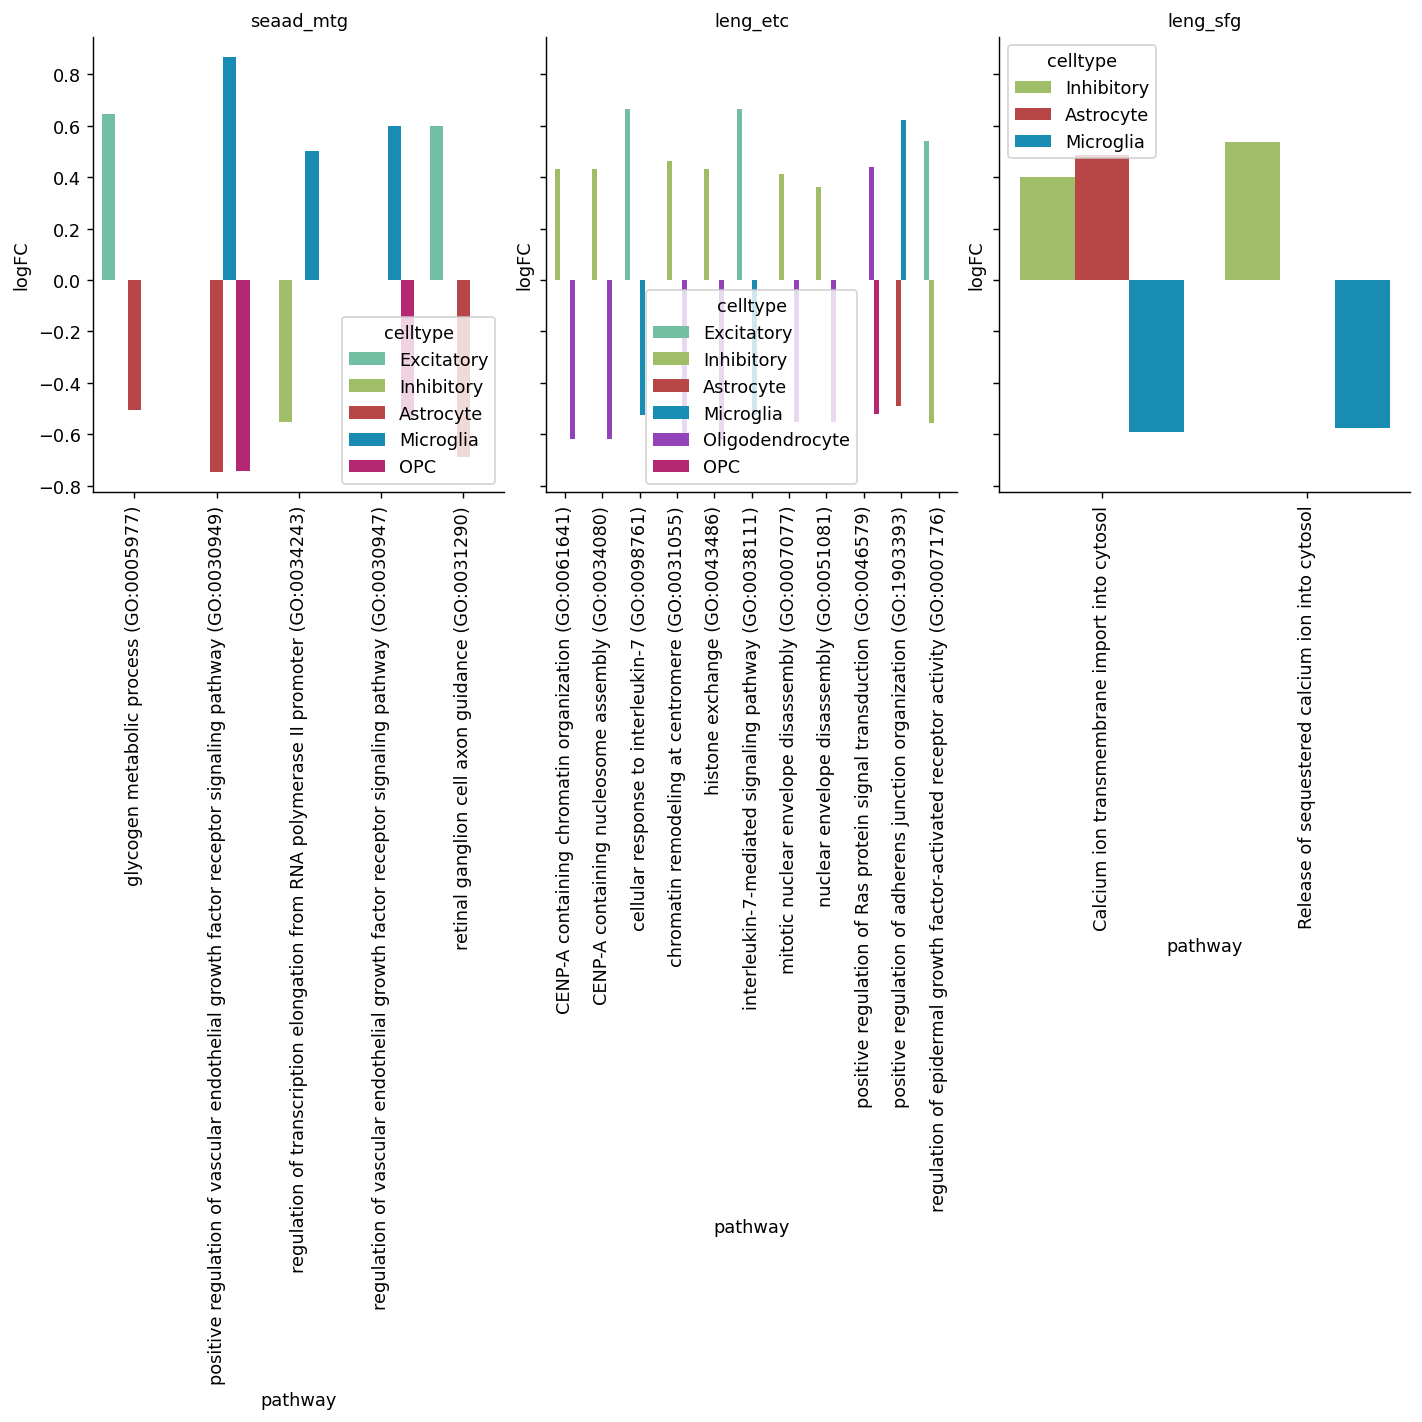

Directionality of pathways in all studies in AD_VS_NO
Number of pathways with opposing directionality in SEAAD_MTG: 134
Number of pathways with opposing directionality in LENG_ETC: 103
Number of pathways with opposing directionality in LENG_SFG: 66


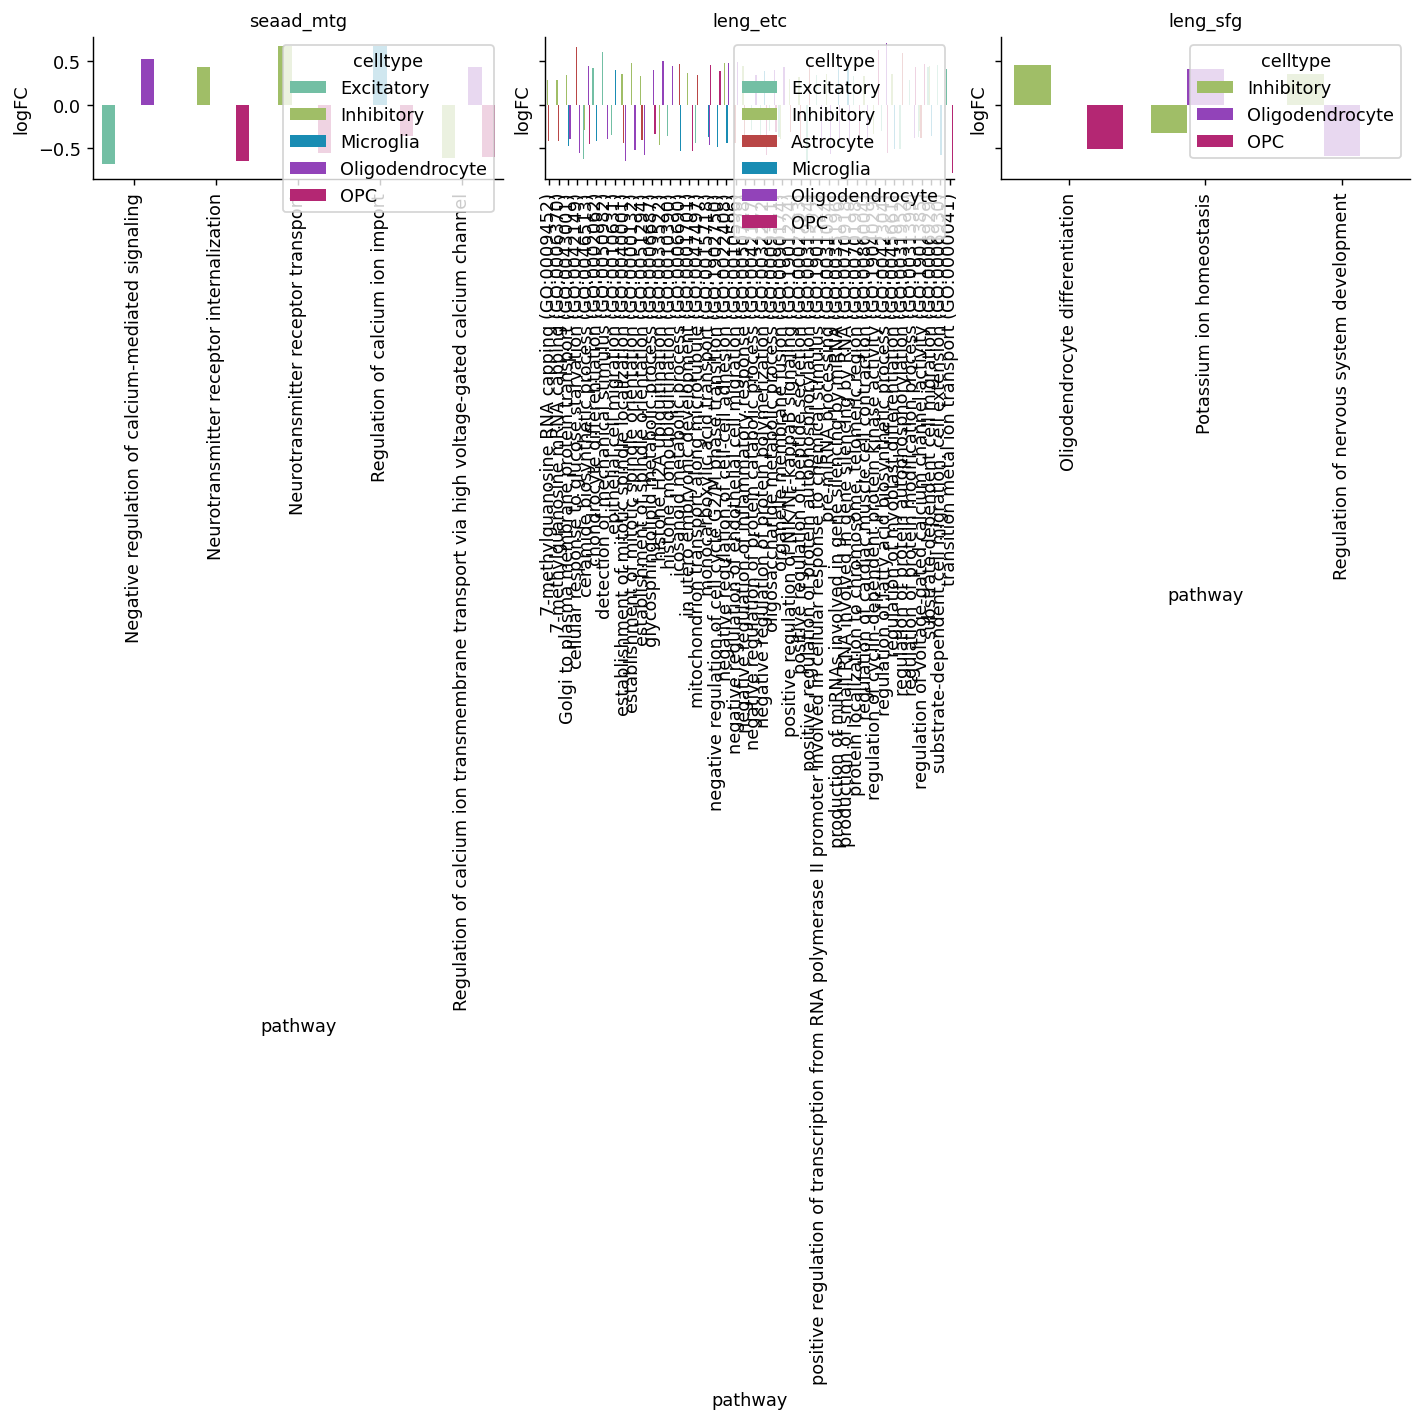

Directionality of pathways in all studies in LATE_VS_NO
Number of pathways with opposing directionality in SEAAD_MTG: 70
Number of pathways with opposing directionality in LENG_ETC: 80
Number of pathways with opposing directionality in LENG_SFG: 49


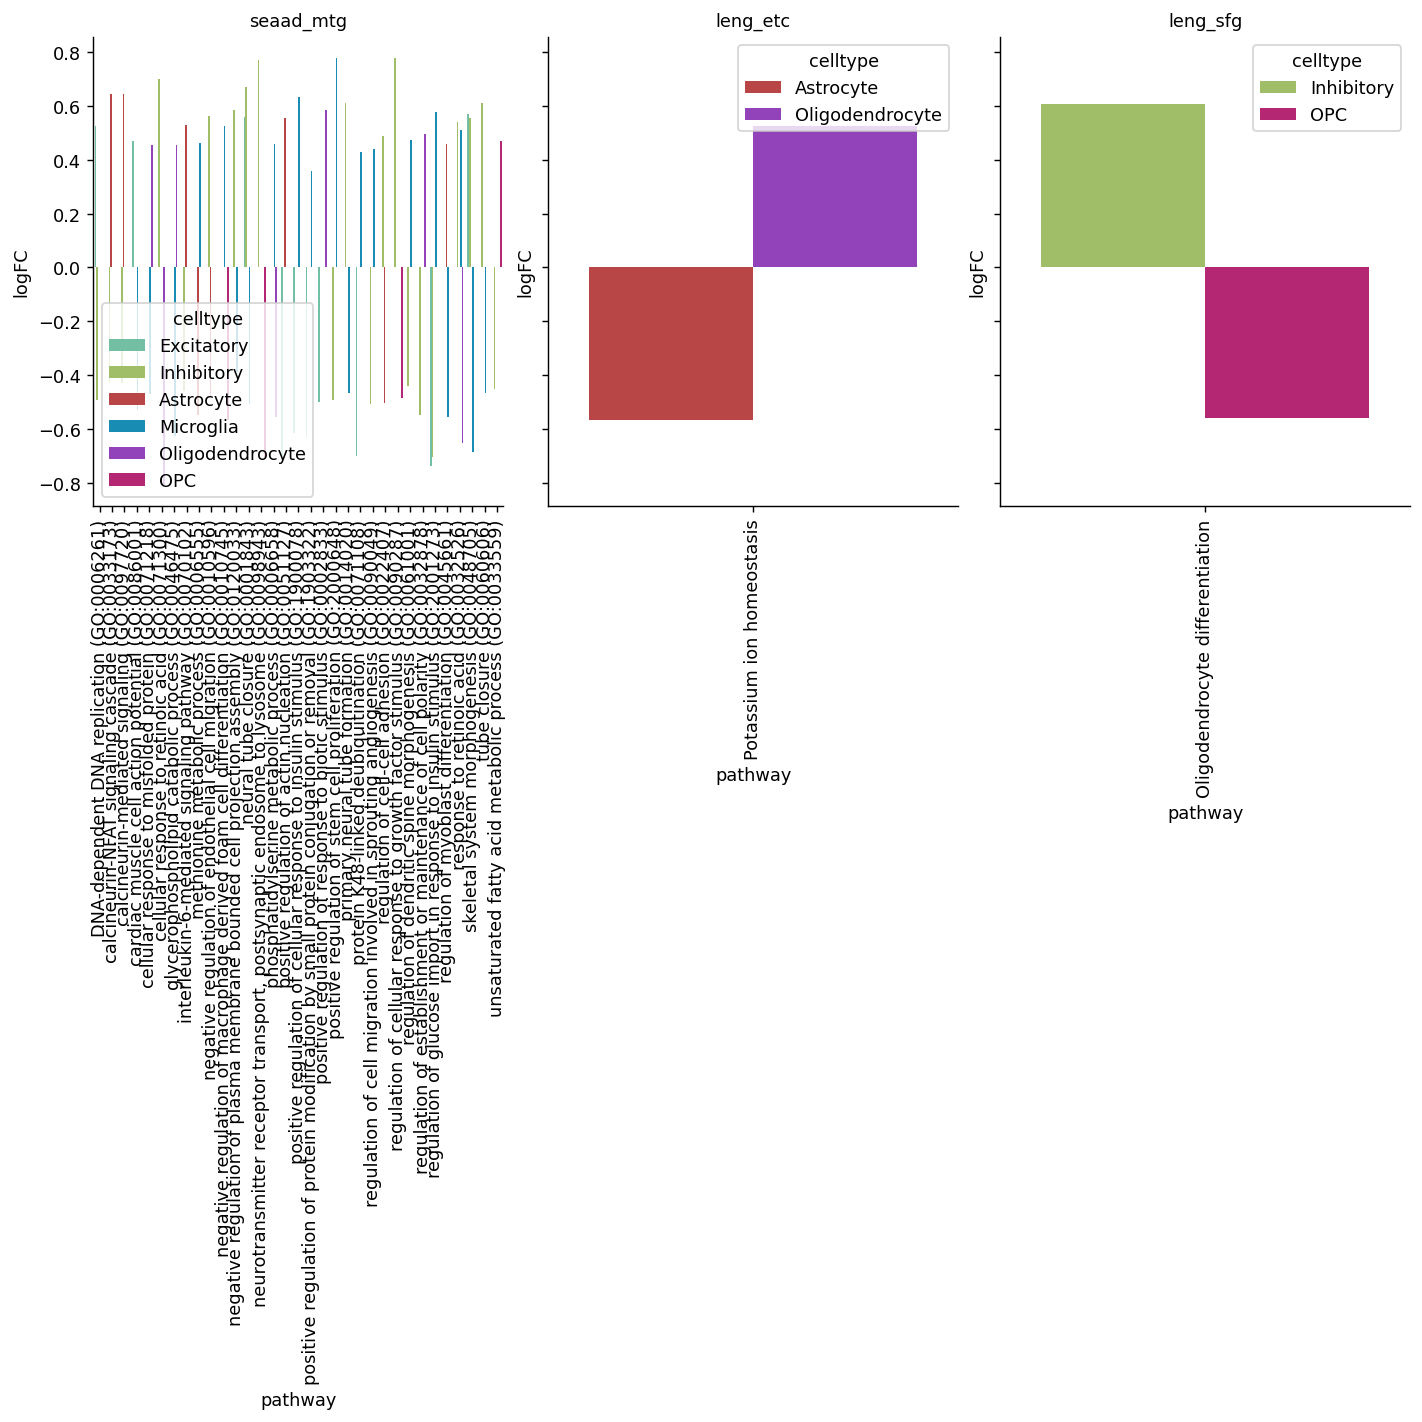

In [18]:
for test_name in tests:
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 11), sharex=False, sharey = True, layout='constrained')
    axs = axs.ravel()

    print(f'Directionality of pathways in all studies in {test_name.upper()}')

    for ind, study in enumerate(studies):
        df = pathway_scores[study][test_name][pathway_scores[study][test_name].celltype.isin(cell_types)]
        df = df[abs(df.score_adj)>1.3]
        df['Direction'] = df.score_adj.apply(lambda x: 'down' if x<0 else "up")
        df = df[df.pathway.isin([key for key, value in dict(df['pathway'].value_counts() > 1).items() if value == True])]
        keys = dict(df.groupby('pathway')['Direction'].value_counts()).keys()
        
        pathways = [key[0] for key in keys if ((key[0], "down") in keys) and ((key[0], "up") in keys)]


        df = df[df.pathway.isin(pathways)]

        print(f'Number of pathways with opposing directionality in {study.upper()}: {len(df)}')

        if len(df[df.pathway.isin(list_of_paths_to_annotate)])>0:
            
            df = df[df.pathway.isin(list_of_paths_to_annotate)]
            df['pathway'] = df['pathway'].map(dict(zip(pathways_to_annotate.pathway,
                                                       pathways_to_annotate.shortened_name)))
           
        sb.barplot(data=df, x='pathway', y='logFC', hue='celltype', 
                   hue_order = sorted(list(df.celltype.unique()), key=lambda x: cell_types.index(x)),
                     ax=axs[ind], linewidth=4, #order=cell_types, 
                     palette={'Excitatory': [x/255 for x in [102, 204, 168]], 
                              'Inhibitory':  [x/255 for x in [164, 204, 89]],
                              'Astrocyte':  [x/255 for x in [204, 51, 51]],
                              'Microglia':  [x/255 for x in [0, 153, 204]],
                              'Oligodendrocyte':  [x/255 for x in [153, 48, 204]],
                              'OPC':  [x/255 for x in [204, 15, 117]],
                              
                              },
                     )


        axs[ind].set_title(study, fontdict={'fontsize': 10})
        axs[ind].yaxis.label.set_fontsize(10)
        axs[ind].set_xticklabels(df.pathway.unique(), rotation=90,)
        axs[ind].spines[['right', 'top']].set_visible(False)


    fig_dir = f'../results/{test_name}/Consensus/BarChat/'

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
         
    plt.savefig(fig_dir+'directionality_of_select_pathways.pdf')
    plt.show()
    

### **Upset plot to show how many pathways are shared & how many are cell type specific in each study**

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observat

In addition: There were 26 warnings (use warnings() to see them)


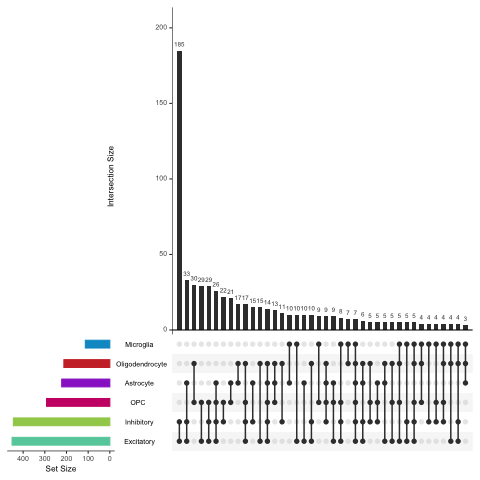

In [19]:
%%R -o upset_df 


all_combinations <- lapply(2:length(cell_types), function(k) combn(cell_types, k, simplify = FALSE))

pathway_scores <- list()

for (study in studies) {
  pathway_scores[[study]] <- list()
    for (test in tests) {
    # Read in pathway data from a CSV file for the current test and study
    all_pathways <- read.csv(sprintf('../results/%s/%s/Data/differentially_expressed_pathways.csv', test, study), header=TRUE)
    
    # Filter the pathway data to select only significant pathways
    pathway_scores[[study]][[test]] <- all_pathways[abs(all_pathways["score_adj"]) > 1.3, ]
  }
}

upset_df <- list() 
for(study in studies){
  upset_df[[study]] <- list()
  for(test_name in tests){ 
    scores <- pathway_scores[[study]][[test_name]] # subset the pathway scores dataframe to only include pathways that are common to all cell types in the current test
    scores$celltype <- as.character(scores$celltype) 
    scores$pathway <- factor(as.character(scores$pathway), levels=unique(scores$pathway))  

    upset_list <- list()  

    for(cur_celltype in cell_types){ 
      test_df <- scores %>% subset(celltype == cur_celltype) 
      upset_list[[cur_celltype]] <- table(test_df$pathway) 
    }

    upset_df[[study]][[test_name]] <- as.data.frame(Reduce(cbind, upset_list))
    colnames(upset_df[[study]][[test_name]]) <- cell_types

    # remove entries with all 0
    upset_df[[study]][[test_name]] <- upset_df[[study]][[test_name]][rowSums(upset_df[[study]][[test_name]]) > 0,]
  
    # convert to binary
    upset_df[[study]][[test_name]][upset_df[[study]][[test_name]] > 0] <- 1

    fig_dir = paste0('../results/', test_name, '/', study, '/Upset/')

    if (!dir.exists(fig_dir)) {
      dir.create(fig_dir, recursive=TRUE)
    }
    
    col_names <- colnames(upset_df[[study]][[test_name]])

    cur_color_scheme <- unlist(color_scheme_celltype)[match(col_names, names(color_scheme_celltype))]

    cur_color_scheme <- cur_color_scheme[order(colSums(upset_df[[study]][[test_name]]), decreasing = TRUE)]
    
    unique <- upset_df[[study]][[test_name]][rowSums(upset_df[[study]][[test_name]])<=1, ]
    shared <- upset_df[[study]][[test_name]][rowSums(upset_df[[study]][[test_name]])>=2, ]

    svg(paste0(fig_dir, 'upset_individual_unique_', study, '.svg'), width=8, height=4)
    print(upset(unique,
              sets=as.character(cell_types),
              #group.by='sets',
              order.by='freq',
              #cutoff=4,
              sets.bar.color=cur_color_scheme,
            ))

    
    col_names <- colnames(unique)

    cur_color_scheme <- unlist(color_scheme_celltype)[match(col_names, names(color_scheme_celltype))]

    cur_color_scheme <- cur_color_scheme[order(colSums(unique), decreasing = TRUE)]

    pdf(paste0(fig_dir, 'upset_individual_unique_', study, '.pdf'), width=8, height=4)
    print(upset(unique,
              sets=as.character(cell_types),
              #group.by='sets',
              order.by='freq',
              #cutoff=4,
              sets.bar.color=cur_color_scheme,
            ))

    dev.off()

    svg(paste0(fig_dir, 'upset_individual_shared_', study, '.svg'), width=8, height=4)
    print(upset(shared,
              sets=as.character(cell_types),
              #group.by='sets',
              order.by='freq',
              #cutoff=4,
              sets.bar.color=cur_color_scheme,
            ))
    
    col_names <- colnames(shared)

    cur_color_scheme <- unlist(color_scheme_celltype)[match(col_names, names(color_scheme_celltype))]

    cur_color_scheme <- cur_color_scheme[order(colSums(shared), decreasing = TRUE)]

    pdf(paste0(fig_dir, 'upset_individual_shared_', study, '.pdf'), width=8, height=4)
    print(upset(shared,
              sets=as.character(cell_types),
              #group.by='sets',
              order.by='freq',
              #cutoff=4,
              sets.bar.color=cur_color_scheme,
            ))

    dev.off()
  }
}

### **Heatmap Visualizing Shared Differential Pathway Expression Across All Studies**

In [20]:
pathways_to_annotate = pd.read_excel('../data/pathway_databases/pathways_to_annotate.xlsx')
filtered_pathways = pathways_to_annotate['pathway'].to_list()

In [21]:
%%R -o common_pathways -o valid_test_names


source('../scripts/functions/pathway_analyses.R')

cell_types = c("Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC")

print('importing pathway renaming convention')

path_names_go <- as.data.frame(read_excel('../data/pathway_databases/pathways_to_annotate.xlsx'))
# path_names_go <- data.frame(pathway = unique(path_names_go$pathway))
rownames(path_names_go) <- path_names_go$pathway

names = as.vector(list_of_paths_to_annotate)
names = rownames(path_names_go)

pathway_scores <- list()

for (study in studies) {
  pathway_scores[[study]] <- list()
    for (test_name in tests) {
    all_pathways <- read.csv(sprintf('../results/%s/%s/Data/differentially_expressed_pathways.csv', test_name, study), header=TRUE)
    pathway_scores[[study]][[test_name]] <- all_pathways[abs(all_pathways["score_adj"]) > 1.3, ]
  }
}


common_pathways <- list()

for (test_name in tests) {
  
  cur_study_pathways <- list()
  
  for (study in studies) {
    cur_study_pathways[[study]] <- pathway_scores[[study]][[test_name]]

    cur_study_pathways[[study]] <- as.character(unique(cur_study_pathways[[study]]$pathway))
  }
  
  common_pathways[[test_name]] <- Reduce(intersect, cur_study_pathways)
  common_pathways[[test_name]] <- intersect(common_pathways[[test_name]], names)

  if (length(common_pathways[[test_name]])==0){
    common_pathways[[test_name]] <- NULL
  }
  
}

valid_test_names <- names(common_pathways)


for (test_name in valid_test_names) {

  tryCatch({

  h <- list()
  ha <- NULL

  for (study in studies) {

    scores <- pathway_scores[[study]][[test_name]][pathway_scores[[study]][[test_name]]$pathway %in% common_pathways[[test_name]], ]

    
    # Filter the pathway data to select only significant pathways
    scores[abs(scores$score_adj) < 1.3, "score_adj"] <- 0
    pathway_scores_subset <- scores[, c("pathway", "celltype", "score_adj")]
    pivot_table <- pathway_scores_subset %>% pivot_wider(names_from = "celltype", values_from = "score_adj")

    pivot_table <- as.data.frame(pivot_table)

    row.names(pivot_table) <- pivot_table$pathway

    pivot_table$pathway <- NULL
    ct_order <- intersect(cell_types, colnames(pivot_table))
    mat <- pivot_table[, ct_order]
    mat <- mat[rownames(mat) %in% path_names_go$pathway, ] 
    mat <-  mat %>%
        mutate_all(~coalesce(., 0))
    # draw heatmap for all GO pathways
    print('drawing heatmaps - GO')
    h[[study]] = get_go_hmap(mat, names, path_names_go, 
                            'shortened_name', cell_type_order=ct_order,
                            reorder=TRUE)

  }

  fig_dir = paste0('../results/', test_name, '/Consensus/HeatMap/')

  if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
  }

  pdf(paste0(fig_dir, 'filtered_multi_study_pathway_overlap_R.pdf'), height = 21, width = 55.5)
  print(Reduce('+', h))
  dev.off()

}, error = function(e) {
    # Print the error message
    cat("Error occurred for test:", test_name, "\n")
    message(e)
    # Continue to the next iteration
    return()
  })
}


[1] "importing pathway renaming convention"
New names:
• `` -> `...1`
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
Error occurred for test: late_vs_early 
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"


incorrect number of dimensions

#### **Save overlapping pathways With Stats and Brain Region Info**

In [22]:
overlap_paths = {}
for test_name in tests:
    frames = []
    for study in studies:
        select_paths = pathway_scores[study][test_name][
            pathway_scores[study][test_name].pathway.isin(common_pathways[test_name])
        ].copy()
        select_paths.loc[:, 'Brain Region'] = study.split('_')[-1].upper()
        frames.append(select_paths)
    overlap_paths[test_name] = pd.concat(frames, ignore_index=True)
    overlap_paths[test_name] = overlap_paths[test_name][['pathway', 'celltype', 'Brain Region', 'score_adj', 'P.Value', 'logFC',]]
    overlap_paths[test_name] = overlap_paths[test_name].merge(pathways_to_annotate[['pathway', 'shortened_name']], how='left', on='pathway')
    overlap_paths[test_name].to_excel(f'../results/{test_name}/Consensus/pathway_overlap_with_brain_region_and_stats.xlsx')


### **Venn Diagrams showing number of overlapping pathways across all studiess in each cell type**

In addition: There were 24 warnings (use warnings() to see them)


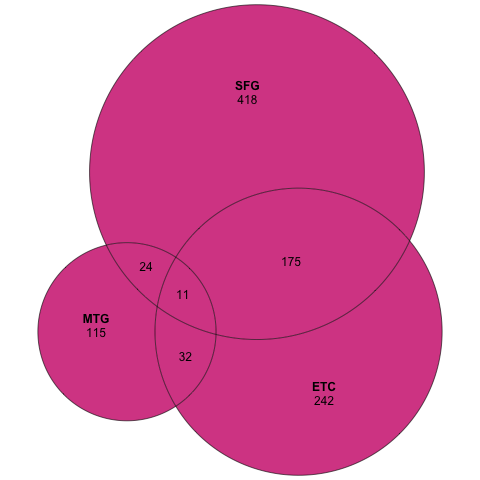

In [23]:
%%R 

pathway_scores <- list()
studies <- studies
all_pathways <- list()
for (study in studies) {
  pathway_scores[[study]] <- list()
  all_pathways[[study]] <- list()
  for (test in tests) {
    all_pathways[[study]][[test]] <- read.csv(sprintf('../results/%s/%s/Data/differentially_expressed_pathways.csv', test, study), header=TRUE)
    
    pathway_scores[[study]][[test]] <- all_pathways[[study]][[test]][abs(all_pathways[[study]][[test]]["score_adj"]) > 1.3, ]
  }
}

library(GeneOverlap)


for(test_name in valid_test_names){
    
  for(cur_celltype in cell_types){
    
      # get celltype degs for this celltype:
      overlap_df <- data.frame()
      pathway_set_list <- list()
      for (study in studies){
        cur_celltype_pathways <- pathway_scores[[study]][[test_name]] %>% subset(celltype == cur_celltype)
        pathway_set_list[[toupper(tail(strsplit(study, "_")[[1]], -1))]] = as.character(unique(cur_celltype_pathways$pathway))
        for (study2 in studies){
          if (study!=study2){
            cur_celltype_pathways2 <- pathway_scores[[study2]][[test_name]] %>% subset(celltype == cur_celltype)
            genome.size <- nrow(all_pathways[[study]][[test]] %>% subset(celltype == cur_celltype)) + nrow(all_pathways[[study2]][[test]] %>% subset(celltype == cur_celltype))

            gene_set1 <- as.character(unique(cur_celltype_pathways$pathway))
            gene_set2 <- as.character(unique(cur_celltype_pathways2$pathway))

            cur_overlap <- testGeneOverlap(newGeneOverlap(gene_set1, gene_set2, genome.size = genome.size))

            temp_df <- data.frame(
              'odds.ratio' = cur_overlap@odds.ratio,
              'pval' = cur_overlap@pval,
              'Jaccard' = cur_overlap@Jaccard,
              'size_intersection' = length(cur_overlap@intersection),
              'combination' = paste(study, study2, sep = "_")  # Concatenate study names
            )
            
            overlap_df <- rbind(overlap_df, temp_df)
          }
        }
      }

      fig_dir = paste0('../results/', test_name, '/Consensus/Venn/')

      if (!dir.exists(fig_dir)) {
      dir.create(fig_dir, recursive=TRUE)
      }

      write.csv(overlap_df, paste0(fig_dir, 'overlap_stats_', cur_celltype, ".csv"), row.names = FALSE)

      venn_list <- list()
      for(i in 1:length(pathway_set_list)){
        cur_pathways <- pathway_set_list[[i]]
    
        other_indices <- (i:length(pathway_set_list))[i:length(pathway_set_list) != i]
    
        # number of pathways in cur set and not other sets:
        venn_list[[names(pathway_set_list)[i]]] <- sum(!(cur_pathways %in% Reduce(union, 
                                                        pathway_set_list[other_indices])))
    
    
        for(j in other_indices){
          other_pathways <- pathway_set_list[[j]]
          venn_list[[paste0(names(pathway_set_list)[i],'&',
                    names(pathway_set_list)[j])]] <- length(intersect(cur_pathways, other_pathways))
        }
      }
    
      # number of pathways in common between all sets:
      venn_list[[paste0(names(pathway_set_list)[1], '&',
                        names(pathway_set_list)[2], '&', 
                        names(pathway_set_list)[3])]] <- length(Reduce(intersect, pathway_set_list))
    


      VennDiag <- euler(unlist(venn_list))
      svg(paste0(fig_dir, 'venn_',cur_celltype,'.svg'), width=6, height=6)
  
      print(plot(
        VennDiag, quantities=TRUE, counts = TRUE, font=5, cex=1, alpha=0.8,
        fill=rep(color_scheme_celltype[[cur_celltype]], 3)
      ))

      pdf(paste0(fig_dir, 'venn_',cur_celltype,'.pdf'), width=6, height=6)  
      print(plot(
        VennDiag, quantities=TRUE, counts = TRUE, font=5, cex=1, alpha=0.8,
        fill=rep(color_scheme_celltype[[cur_celltype]], 3)
      ))
      dev.off()

    }
}

### **Circular HeatMap for DEGs in all pathways for each test**

#### **Plot Genes In Each Differentially Expressed Pathway For Each Study**


**First, obtain a list of genes that are in differentially expressed in pathways for each cell type across all studies and tests**

In [24]:
%%R -o geneSets


geneSets <- list()
pathway_names <- list()
for(test_name in tests){

  geneSets[[test_name]] <- list()
  pathway_names[[test_name]] <- list()

  for (study in studies){

    all_pathways <- read.csv(sprintf('../results/%s/%s/Data/differentially_expressed_pathways.csv', test_name, study), header=TRUE)
    
    all_pathways <- all_pathways[abs(all_pathways["score_adj"]) > 1.3, ]

    pathway_names[[test_name]][[study]] <- list()
    geneSets[[test_name]][[study]] <- list()

    for (cur_celltype in cell_types){

        subset_df <- all_pathways %>% subset(celltype == cur_celltype)
        pathway_names[[test_name]][[study]][[cur_celltype]] <- subset_df$pathway

        # get gene sets
        geneSets[[test_name]][[study]][[cur_celltype]] <- getGmt(file.path('../results/gsva/', study, '/', cur_celltype, 'gs.gmt'))
        geneSets[[test_name]][[study]][[cur_celltype]] <- geneIds(geneSets[[test_name]][[study]][[cur_celltype]])

        # Check if test_name exists
        if (test_name %in% valid_test_names) {
          geneSets[[test_name]][[study]][[cur_celltype]] <-  geneSets[[test_name]][[study]][[cur_celltype]][names(geneSets[[test_name]][[study]][[cur_celltype]]) %in% pathway_names[[test_name]][[study]][[cur_celltype]]]
          } else {
          geneSets[[test_name]][[study]][[cur_celltype]] <- character(0)  # Set an empty vector if no scores exist
        }
        geneSets[[test_name]][[study]][[cur_celltype]] <- unlist(geneSets[[test_name]][[study]][[cur_celltype]], recursive = FALSE)
    }
  }
}

**Next, obtain the dataframe of P-values and LogFC for each gene in the genesetfor each cell type across all studies and tests**

In [70]:
degs = {}
merged_degs = {}
merged_is_degs = {}
DEG_dist = {}


def assign_deg(row):
    if row['avg_logFC'] > 0.25 and row['p_val_adj'] < 0.01:
        return 1
    elif row['avg_logFC'] < -0.25 and row['p_val_adj'] < 0.01:
        return -1
    else:
        return 0


for study in studies:

    degs[study] = {}
    merged_degs[study] = {}
    merged_is_degs[study] = {}
    DEG_dist[study] = {}

    for test in tests:
      
        degs[study][test] = {}
        merged_degs[study][test] = {}
        merged_is_degs[study][test] = {}
        DEG_dist[study][test] = {}

        for method in deg_methods:
         
            degs[study][test][method] = {}
            merged_degs[study][test][method] = {}
            merged_is_degs[study][test][method] = {}
            merged_df = pd.DataFrame(columns=['gene'])
 
            deg_distribution = {}
            deg_distribution['Cell Type'] = []
            deg_distribution['Gene Program'] = []
            deg_distribution['Up'] = []
            deg_distribution['Down'] = []

            for cell_type in cell_types:
                degs[study][test][method][cell_type] = pd.read_excel(f'../results/{test}/{study}/DEG/{method}_degs.xlsx', 
                                                                            sheet_name=cell_type,)
                
                
                df = degs[study][test][method][cell_type]
                df = df[df.gene.isin(geneSets[test][study][cell_type])]

                deg_distribution['Cell Type'].append(cell_type)
                deg_distribution['Gene Program'].append(len(df))
                deg_distribution['Up'].append(len(df[(df.avg_logFC>0.25)&(df.p_val_adj<0.01)]))
                deg_distribution['Down'].append(len(df[(df.avg_logFC<-0.25)&(df.p_val_adj<0.01)]))

                df.loc[:, f'{cell_type}_is_DEG'] = df.apply(assign_deg, axis=1).astype(int)
                df = df.rename(columns={'avg_logFC': f'{cell_type}_logFC', 'p_val_adj': f'{cell_type}_Pvalue'})
            
                merged_df = pd.merge(merged_df, df[['gene', f'{cell_type}_logFC', f'{cell_type}_Pvalue', f'{cell_type}_is_DEG']], on='gene', how='outer')
        
            merged_degs[study][test][method]['logFC'] = merged_df[['gene'] + list(merged_df.filter(like='logFC').columns)]
            merged_degs[study][test][method]['Pvals'] = merged_df[['gene'] + list(merged_df.filter(like='Pvalue').columns)]
            merged_is_degs[study][test][method] = merged_df[['gene'] + list(merged_df.filter(like='is_DEG').columns)]
            merged_is_degs[study][test][method].set_index('gene', inplace=True)

            DEG_dist[study][test][method] = pd.DataFrame(deg_distribution)

# convert nested dataframe into Rpy2 object 

all_degs =  robjects.ListVector(
                        {
                            study: robjects.ListVector(
                                {
                                    test_name: robjects.ListVector(
                                        {
                                            method: robjects.ListVector(
    
                                                pandas2ri.py2rpy(merged_is_degs[study][test_name][method])

                                            )
                                            for method in deg_methods
                                        }
                                    )
                                    for test_name in tests
                                }
                            )
                            for study in studies
                        }
                    )


DEG_dist =  robjects.ListVector(
                        {
                            study: robjects.ListVector(
                                {
                                    test_name: robjects.ListVector(
                                        {
                                            method: robjects.ListVector(
    
                                                pandas2ri.py2rpy(DEG_dist[study][test_name][method])
                                                 
                                            )
                                            for method in deg_methods
                                        }
                                    )
                                    for test_name in tests
                                }
                            )
                            for study in studies
                        }
                    )

/var/folders/70/42xwxjh94x5f164djlw1hwpc0000gv/T/ipykernel_10316/3906552962.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'{cell_type}_is_DEG'] = df.apply(assign_deg, axis=1).astype(int)
/var/folders/70/42xwxjh94x5f164djlw1hwpc0000gv/T/ipykernel_10316/3906552962.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'{cell_type}_is_DEG'] = df.apply(assign_deg, axis=1).astype(int)
/var/folders/70/42xwxjh94x5f164djlw1hwpc0000gv/T/ipykernel_10316/3906552962.py:56: SettingWithCopyWarn

**Obtain Table of DEG distributions in perturbed gene programs**

In [71]:
%%R -i all_degs -i deg_methods -i DEG_dist

library(knitr)
library(kableExtra)
library(magrittr)

for (study in studies){
  for (test_name in tests){

    fig_dir = paste0('../results/', test_name, '/', study, '/DEG_distribution/')

    if (!dir.exists(fig_dir)) {
    dir.create(fig_dir, recursive=TRUE)
    }

    if (test_name %in% valid_test_names) {
      for (method in deg_methods){
        rownames(DEG_dist[[study]][[test_name]][[method]]) = DEG_dist[[study]][[test_name]][[method]][, 'Cell Type']
        # Create the table using kable and style it with kableExtra
        kable(DEG_dist[[study]][[test_name]][[method]][, c("Gene Program", "Up", "Down")], "html", booktabs = TRUE) %>%
          kable_styling(bootstrap_options = c("striped", "hover"), full_width = F) %>%
          save_kable(paste0(fig_dir, 'deg_distribution_', method, '.pdf'))

      }
    }
  }
}

# Print the new data frame to check


Note that HTML color may not be displayed on PDF properly.
save_kable will have the best result with magick installed. 
Note that HTML color may not be displayed on PDF properly.
save_kable will have the best result with magick installed. 
Note that HTML color may not be displayed on PDF properly.
save_kable will have the best result with magick installed. 
Note that HTML color may not be displayed on PDF properly.
save_kable will have the best result with magick installed. 
Note that HTML color may not be displayed on PDF properly.
save_kable will have the best result with magick installed. 
Note that HTML color may not be displayed on PDF properly.
save_kable will have the best result with magick installed. 
Note that HTML color may not be displayed on PDF properly.
save_kable will have the best result with magick installed. 
Note that HTML color may not be displayed on PDF properly.
save_kable will have the best result with magick installed. 
Note that HTML color may not be displaye

**Next, Make Circos plot using this filtered data**

In [81]:
%%R 

library(viridis)

for (study in studies){
  for (test_name in tests){

    if (test_name %in% valid_test_names) {
      for (method in deg_methods){

        mat3 = all_degs[[study]][[test_name]][[method]]
        mat3[is.na(mat3)] <- 0        
        mat3 <- mat3[sample(1:nrow(mat3)), ]
        
        fig_dir = paste0('../results/', test_name, '/', study, '/DEG/')

        if (!dir.exists(fig_dir)) {
        dir.create(fig_dir, recursive=TRUE)
        }

        pdf(paste0(fig_dir, 'circular_heatmap_', method, '.pdf'), width=8, height=8)

        col_fun1 = colorRamp2(c(-5, 0, 5), c("blue", "white", "red"))
        col_fun2 = colorRamp2(c(0, 6), c("white", "green"))
        col_fun3 = colorRamp2(c(-1, 0, 1), c('purple', "lightgrey", "yellow"))
        
        #circos.initialize()
        circos.par(gap.after = 10)
        # circos.heatmap.initialize(mat3)

        circos.heatmap(mat3, split = NULL, col = col_fun3, track.height = 0.4, bg.border = "black", bg.lwd = 2,)

        circos.track(track.index = get.current.track.index(), panel.fun = function(x, y) {
        if(CELL_META$sector.numeric.index == 1) { # the last sector
            cn = lapply(colnames(mat3), function(col_name) toupper(substr(col_name, 1, 3)))
            cn = rev(as.vector(cn))
            n = length(cn)
            circos.text(rep(CELL_META$cell.xlim[2], n) + convert_x(1, "mm"), 
                1:n - 0.5, cn, 
                cex = 0.5, adj = c(0, 0.5), facing = "inside")
          }
        }, bg.border = NA)

        print(circos.par(gap.after = c(90)))
        circos.clear()
        dev.off()
             
      } 
    } 
  }
}

NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL


Note: 6 points are out of plotting region in sector 'group', track '1'.
Note: 6 points are out of plotting region in sector 'group', track '1'.
Note: 6 points are out of plotting region in sector 'group', track '1'.
Note: 6 points are out of plotting region in sector 'group', track '1'.
Note: 6 points are out of plotting region in sector 'group', track '1'.
Note: 6 points are out of plotting region in sector 'group', track '1'.
Note: 6 points are out of plotting region in sector 'group', track '1'.
Note: 6 points are out of plotting region in sector 'group', track '1'.
Note: 6 points are out of plotting region in sector 'group', track '1'.
Note: 6 points are out of plotting region in sector 'group', track '1'.
Note: 6 points are out of plotting region in sector 'group', track '1'.
Note: 6 points are out of plotting region in sector 'group', track '1'.
In addition: There were 12 warnings (use warnings() to see them)


# **hub-DEGs in Each Brain Region and Cell Type**

In [28]:
%%R
suppressPackageStartupMessages({
    library(WGCNA)
    library(Matrix)
    library(viridis)
    library(harmony)
    library(ggpubr)
    library(tictoc)
    library(RColorBrewer)
    library(Hmisc)
    library(corrplot)
    library(grid)
    library(gridExtra)
    library(igraph)
    library(ggrepel)
    library(readxl)
    library(conflicted)
    library(openxlsx)


    # single-cell analysis package
    library(Seurat)

    # plotting and data science packages
    library(tidyverse)
    library(cowplot)
    library(patchwork)

    # co-expression network analysis packages:
    library(WGCNA)
    library(hdWGCNA)

    # gene enrichment packages
    library(enrichR)
    library(GeneOverlap)


    library(GSEABase)
    library(GSVA) 
# needs to be run every time you start R and want to use %>%
})

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

# optionally enable multithreading
# enableWGCNAThreads(nThreads = 4)



In [29]:
KEGG_paths = pathway_analyses.read_pathways('../data/pathway_databases/KEGG_2019_Human.txt')
KEGG_genes = [gene for gene in list(KEGG_paths[(KEGG_paths[0].str.startswith('Alzheimer disease'))].iloc[:, 1:].values[0]) if str(gene)!="nan"]
mayaanlab_genes = pd.read_csv('../data/pathway_databases/AD_genes.csv').Symbol.to_list()
otp_genes = pd.read_csv('../data/pathway_databases/MONDO_0004975-associated-diseases.tsv', sep='\t')
otp_genes = otp_genes[otp_genes.textMining!='No data'].symbol.to_list()

AD_genes = list(set(set(KEGG_genes).union(set(mayaanlab_genes), set(otp_genes))))

In [30]:
%%R -o combined_dfs -i AD_genes

conflicts_prefer(base::intersect)

deg_method =  'DESeq2-Wald'

cell_type_dfs <- list()
test_name = 'ad_vs_no'

for (study in studies){

    for (cell_type in cell_types) {
    
        cat(paste0('Loading data for hdWGCNA Experiment in ', toupper(cell_type), ' for ', study, '\n'))
    
        seurat_obj <- readRDS(paste0("../results/hdWGCNA/SeuratObject/", study, '/', cell_type, '_hdWGCNA_object.rds'))

        pathways <- read.csv(paste0('../results/', test_name, '/', study, '/Data/differentially_expressed_pathways.csv'))
        allowed_pathways <- as.vector(subset(pathways, P.Value < 0.05 & celltype == cell_type)$pathway)

        gmt_data <- getGmt(file.path('../results/gsva/', study, '/', cell_type, 'gs.gmt'))
        gmt_data <- gmt_data[names(gmt_data) %in% allowed_pathways]

        gene_pathway_list <- list()
        for (pathway in names(gmt_data)) {
        gene_set <- geneIds(gmt_data[[pathway]])
            for (gene in gene_set) {
            gene <- as.character(gene)
            if (!is.null(gene_pathway_list[[gene]])) {
            gene_pathway_list[[gene]] <- paste(gene_pathway_list[[gene]], pathway, sep = ", ")
            } else {
            gene_pathway_list[[gene]] <- pathway
            }
        }
        }

        wgcna_genes <- GetWGCNAGenes(seurat_obj)
        degs <- read_excel(paste0('../results/', test_name, '/', study, '/DEG/', deg_method, '_degs.xlsx'), sheet = cell_type)
        degs <- intersect(wgcna_genes, subset(degs, p_val_adj<0.01 & abs_logFC>0.25)$gene)
        
        hub_genes <- GetHubGenes(seurat_obj, 25)
        label_genes <- intersect(hub_genes$gene_name, unique(degs))

        modules <- GetModules(seurat_obj)

        mods <- modules[modules$gene_name %in% hub_genes$gene_name, c('gene_name', 'module', 'color')]

        AD_genes_vector <- unique(as.vector(AD_genes))
        mods$is_AD_related <- ifelse(mods$gene_name %in% AD_genes_vector, 'yes', 'no')

        degs <- read_excel(paste0('../results/', test_name, '/', study, '/DEG/', deg_method, '_degs.xlsx'), sheet = cell_type)
        mods <- merge(mods, degs[, c('gene', 'avg_logFC', 'p_val', 'p_val_adj', 'cell_type')], 
                    by.x = 'gene_name', by.y = 'gene', all.x = TRUE)

        mods$is_DEG <- ifelse(mods$p_val_adj<0.01 & abs(mods$avg_logFC>0.25), 'yes', 'no')

        
        if(nrow(mods)>0){
            mods$brain_region = toupper(unlist(strsplit(study, "_"))[length(unlist(strsplit(study, "_")))])
            

            mods$DE_pathways <- sapply(mods$gene_name, function(gene) {
            # Check if the gene is in the gene_pathway_list
            if(gene %in% names(gene_pathway_list)) {
                # Return the pathways as a string
                return(gene_pathway_list[[gene]])
            } else {
                # Return NA or an empty string if the gene is not in the list
                return(NA)
            }
            })

            cell_type_dfs[[length(cell_type_dfs) + 1]] <- mods   
    
        }
    
    }
}

combined_dfs <- bind_rows(cell_type_dfs)
combined_dfs <- combined_dfs[, c('gene_name', 'module', 'is_AD_related', 'is_DEG', 'cell_type', 'brain_region', 'DE_pathways', 'avg_logFC',	'p_val', 'p_val_adj')]
write.xlsx(combined_dfs, file = paste0('../results/', test_name, '/Consensus/hub_genes_by_pathways_and_study.xlsx'))


[conflicted] Will prefer base::intersect over any other package.


Loading data for hdWGCNA Experiment in EXCITATORY for seaad_mtg
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Loading data for hdWGCNA Experiment in INHIBITORY for seaad_mtg
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Loading data for hdWGCNA Experiment in ASTROCYTE for seaad_mtg
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Loading data for hdWGCNA Experiment in MICROGLIA for seaad_mtg
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Loading data for hdWGCNA Experiment in OLIGODENDROCYTE for seaad_mtg
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Loading data for hdWGCNA Experiment in OPC for seaad_mtg
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Loading data for hdWGCNA Experiment in EXCITATORY for leng_etc
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Loading data for hdWGCNA Experiment in INHIBITORY for leng_etc
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Loading data for hdWGCNA Experiment in ASTROCYTE for leng_etc
New names:
• `` 

In addition: There were 50 or more warnings (use warnings() to see the first 50)


### **Which Hub-Genes are common across brain regions**

In [31]:
test_name = 'ad_vs_no'
hub_genes = pd.read_excel(f'../results/{test_name}/Consensus/hub_genes_by_pathways_and_study.xlsx')

In [32]:

def sort_columns(column):
    if "module" in column:
        return (1, column)
    elif "is_DEG" in column:
        return (2, column)
    elif "DE_Pathways" in column:
        return (3, column)
    else:
        return (0, column)

hub_genes_brain_regions = []

for cell_type in cell_types:
    hub_list = []
    for study in studies:
        hub_filter = hub_genes[(hub_genes.brain_region==study.split('_')[-1].upper())&(hub_genes.cell_type==cell_type)][['gene_name',
                                                                                                                         'cell_type', 
                                                                                                                        'is_AD_related', 
                                                                                                                        'module',
                                                                                                                        'is_DEG', 
                                                                                                                        'DE_pathways']]
        hub_filter.rename(columns={'DE_pathways': f'{study.split("_")[-1].upper()}_DE_Pathways'}, inplace=True)
        hub_filter.rename(columns={'module': f'{study.split("_")[-1].upper()}_module'}, inplace=True)
        hub_filter.rename(columns={'is_DEG': f'{study.split("_")[-1].upper()}_is_DEG'}, inplace=True)  
        hub_filter = hub_filter.set_index('gene_name')
        hub_list.append(hub_filter)

    merged = pd.concat(hub_list, axis=1, join='inner')
    merged = merged.loc[:, ~merged.columns.duplicated()]
    sorted_columns = sorted(merged.columns, key=sort_columns)
    merged = merged[sorted_columns]

    hub_genes_brain_regions.append(merged)

hub_filtered = pd.concat(hub_genes_brain_regions)
hub_filtered['pathway_overlap'] = hub_filtered.apply(lambda row: list(set(row['ETC_DE_Pathways'].split(',')) & set(row['SFG_DE_Pathways'].split(',')) & set(row['MTG_DE_Pathways'].split(','))), axis=1)
hub_filtered['pathway_overlap'] = hub_filtered['pathway_overlap'].apply(lambda x: ','.join(x))
hub_filtered['is_calcium_related'] = hub_filtered.apply(
    lambda row: 'yes' if 'calcium' in row['ETC_DE_Pathways'] or 
                       'calcium' in row['MTG_DE_Pathways'] or 
                       'calcium' in row['SFG_DE_Pathways'] else 'no', 
    axis=1
)

hub_filtered.reset_index(inplace=True)

hub_filtered = hub_filtered[['gene_name',	'cell_type', 'is_AD_related', 'ETC_module',
                            'MTG_module', 'SFG_module', 'ETC_is_DEG','MTG_is_DEG',	
                            'SFG_is_DEG',	'is_calcium_related', 'pathway_overlap', 'ETC_DE_Pathways', 
                            'MTG_DE_Pathways', 'SFG_DE_Pathways']]


In [33]:
hub_filtered.to_excel(f'../results/{test_name}/Consensus/overlapping_hub_genes.xlsx')